In [1]:
import sys
sys.path.append('/lmh_data/work/SEE/train/')
sys.path.append('/lmh_data/work/SEE/analyse/')
import random

import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from matplotlib.ticker import MultipleLocator

from util import array2mat, mkdir

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
map_info = pd.read_csv('/lmh_data/data/sclab/sclab/map_result.csv', sep='\t', index_col=0)
rna = anndata.read_h5ad("/lmh_data/data/sclab/Human_M1_10x/scRNA.h5ad")
rna.obs.cell_type = rna.obs.cell_type.cat.rename_categories({'Oligo': 'ODC'})

gene_name = 'PCDH9'
eval_set = np.load('/lmh_data/data/sclab/sclab/eval_dataset.npy', allow_pickle=True)
preds = np.load('/lmh_data/data/sclab/sclab/tmp/{}/evaluate.npy'.format(gene_name), allow_pickle=True)

In [3]:
rna = rna[map_info.index]
rna = rna[rna.obs['cell_type'].isin(['ODC']),:]
rna.layers["counts"] = rna.X.copy()

In [4]:
_index = []
_rna = rna[:, eval_set[0]['scRNA_head']]
_rna_counts = _rna.layers["counts"].astype(np.int32)
for i in range(len(preds)):
    if eval_set[i]['identity'] == 'fake':
        continue
    if eval_set[i]['cell_type'] not in ['ODC']:
        continue
    for j in range(_rna.shape[0]):
        if (_rna_counts[j] == eval_set[i]['scRNA']).all():
            _index.append(_rna[j].obs.index[0])
            
rna = rna[_index]
rna

View of AnnData object with n_obs × n_vars = 230 × 50281
    obs: 'cell_type', 'domain'
    layers: 'counts'

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be

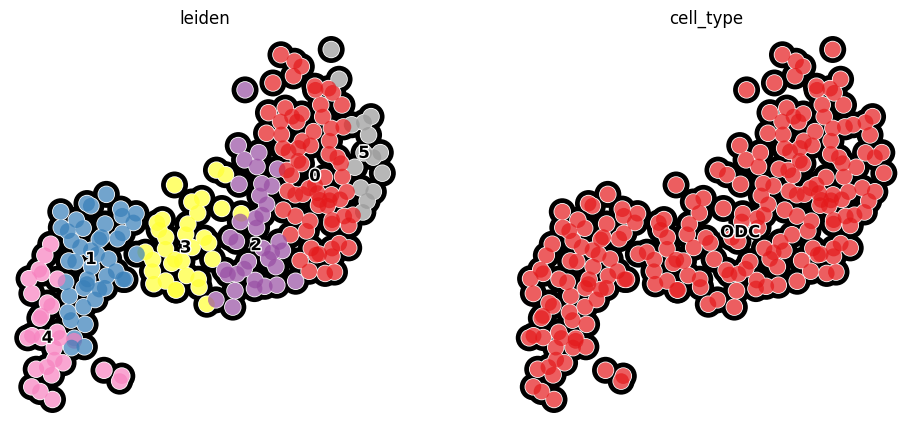

In [5]:
rna.X = rna.layers["counts"].copy()
sc.tl.pca(rna, n_comps=100, svd_solver="auto")

sc.pp.neighbors(rna, metric="cosine")
sc.tl.umap(rna)
sc.tl.leiden(rna)

with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(rna, color=['leiden', 'cell_type'], add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2, frameon=False, palette='Set1')

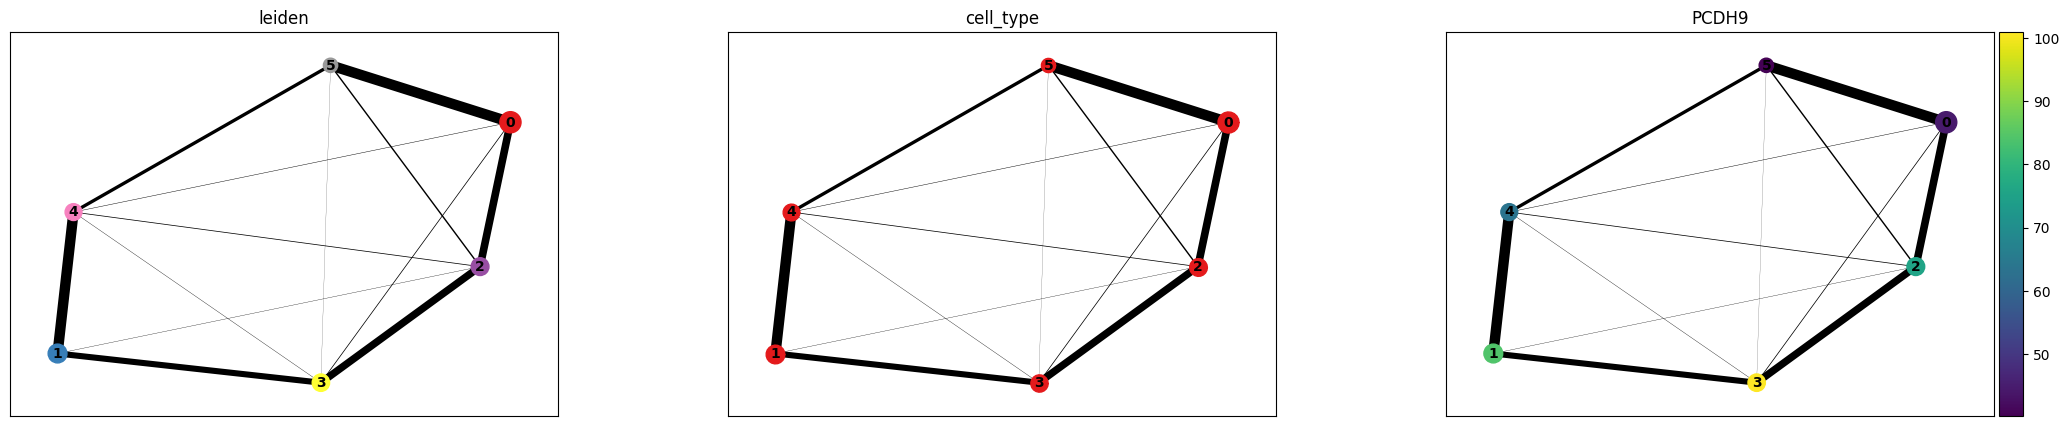

In [6]:
sc.tl.paga(rna, groups='leiden')
sc.pl.paga(rna, color=['leiden', 'cell_type', gene_name])

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


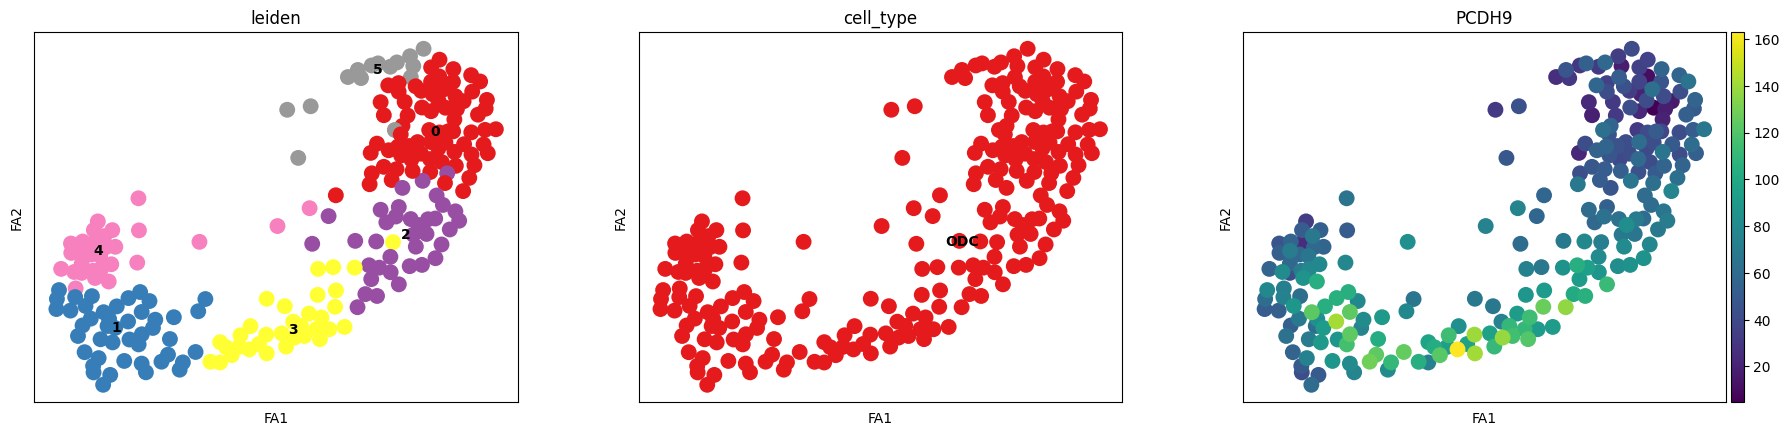

In [7]:
sc.tl.draw_graph(rna, init_pos='paga')
sc.pl.draw_graph(rna, color=['leiden', 'cell_type', gene_name], legend_loc='on data')

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


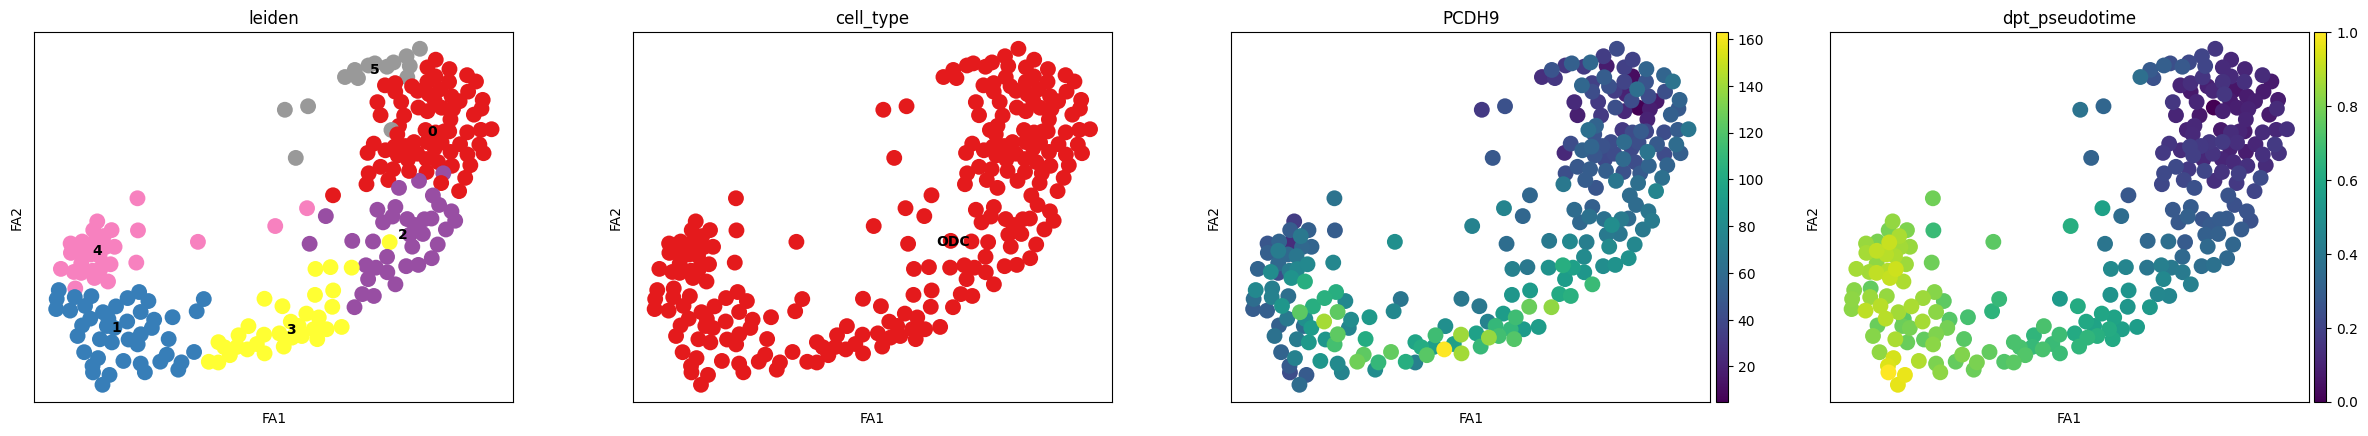

In [8]:
rna.uns['iroot'] = np.flatnonzero(rna.obs['leiden']=='0')[0]
sc.tl.dpt(rna)

sc.tl.draw_graph(rna, init_pos='paga')
sc.pl.draw_graph(rna, color=['leiden', 'cell_type', gene_name, 'dpt_pseudotime'], legend_loc='on data')

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


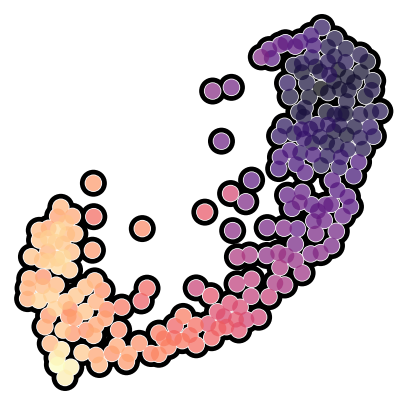

In [9]:
with rc_context({'figure.figsize': (5, 5)}):
    fig = sc.pl.draw_graph(rna, color=['dpt_pseudotime'], cmap='magma',
                     add_outline=True, legend_loc=None, colorbar_loc=None, title='', frameon=False, return_fig=True)
#     plt.savefig(
#         '/lmh_data/work/SEE/analyse/figure_file/pseudotime({}).pdf'.format(gene_name),
#         format='pdf', bbox_inches='tight')
    plt.show()

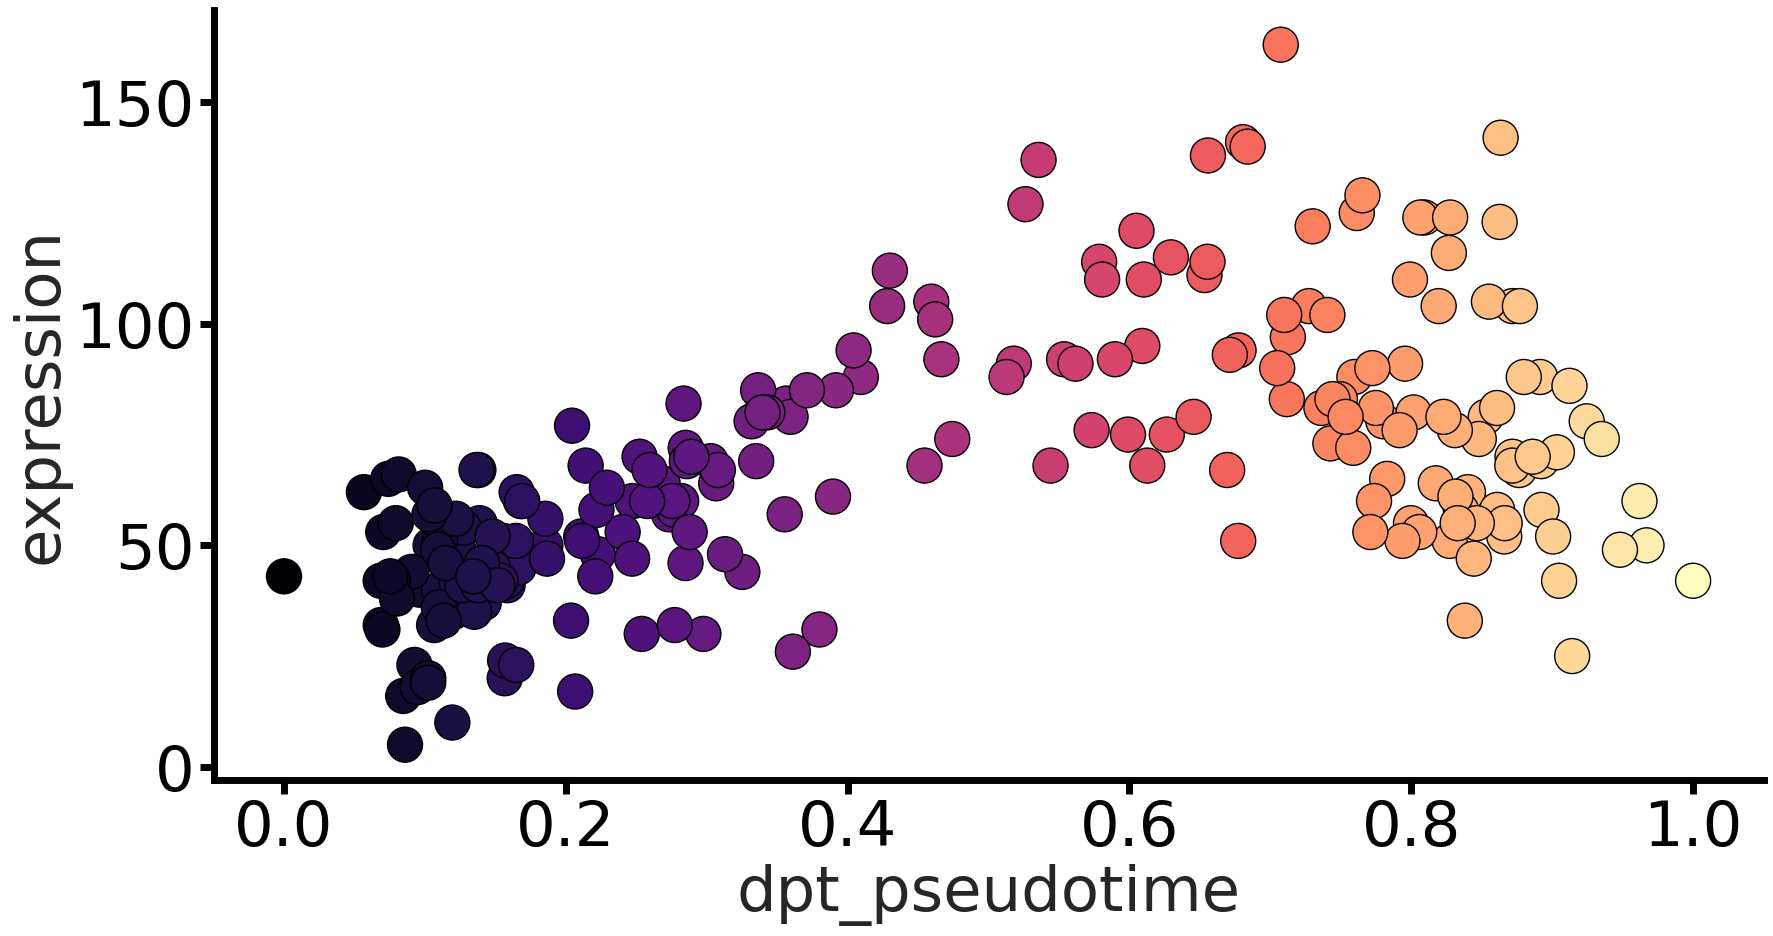

In [10]:
import seaborn as sns
from analyse_util import figure_size, set_plt, set_Border

set_plt(figsize=(20, 10))
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()

_x, _y = rna.obs['dpt_pseudotime'].values, rna[:, gene_name].layers["counts"].reshape(-1)
ax.scatter(_x, _y, edgecolors='black', s=(figure_size['large']*72./fig.dpi)**2, c=_x, cmap='magma')

set_Border(plt.gca())
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])
plt.grid(False)
plt.xlabel('dpt_pseudotime', fontsize=figure_size['ultra'])
plt.ylabel('expression', fontsize=figure_size['ultra'])
# plt.savefig(
#     '/lmh_data/work/SEE/analyse/figure_file/{} expression(ODC).pdf'.format(gene_name),
#     format='pdf', bbox_inches='tight')
plt.show()

In [11]:
scHiC = {}
_rna = rna[:, eval_set[0]['scRNA_head']]
_rna_counts = _rna.layers["counts"].astype(np.int32)
for i in range(len(preds)):
    if eval_set[i]['identity'] == 'fake':
        continue
    if eval_set[i]['cell_type'] not in ['ODC']:
        continue
    for j in range(_rna.shape[0]):
        if (_rna_counts[j] == eval_set[i]['scRNA']).all():
            scHiC[_rna[j].obs_names[0]] = preds[i]['predict']
            break
scHiC

{'CTAAGTGGTGTCCAAT-LKTX_190130_01_F01': array([ 0.34370276  ,  0.0046331584, -0.0010041017, ...,  0.34680688  ,
         0.018684758 ,  0.44119462  ], dtype=float32),
 'TCTCTGGAGATGCAGC-LKTX_190130_01_F01': array([0.37544587  , 0.0061512385, 0.0052283537, ..., 0.3903424   ,
        0.02092893  , 0.48474017  ], dtype=float32),
 'GAGACCCGTAACATAG-LKTX_190129_01_B01': array([0.39431193 , 0.004136486, 0.007325344, ..., 0.41551232 ,
        0.033867694, 0.53073287 ], dtype=float32),
 'ACAACCATCTTCGCTG-LKTX_190129_01_B01': array([0.3855031  , 0.018566791, 0.011411319, ..., 0.4266658  ,
        0.038112886, 0.5438764  ], dtype=float32),
 'CTGGTCTCACTGTGAT-LKTX_190130_01_H01': array([ 0.39329773 ,  0.011369666, -0.000852732, ...,  0.40643105 ,
         0.02949654 ,  0.49014282 ], dtype=float32),
 'TCATGAGGTGGAACCA-LKTX_190130_01_G01': array([ 0.2604801   , -0.0003476795,  0.0039289948, ...,  0.25873238  ,
         0.01386421  ,  0.32176372  ], dtype=float32),
 'TCTGCCACAAGGCTTT-LKTX_190129_01_

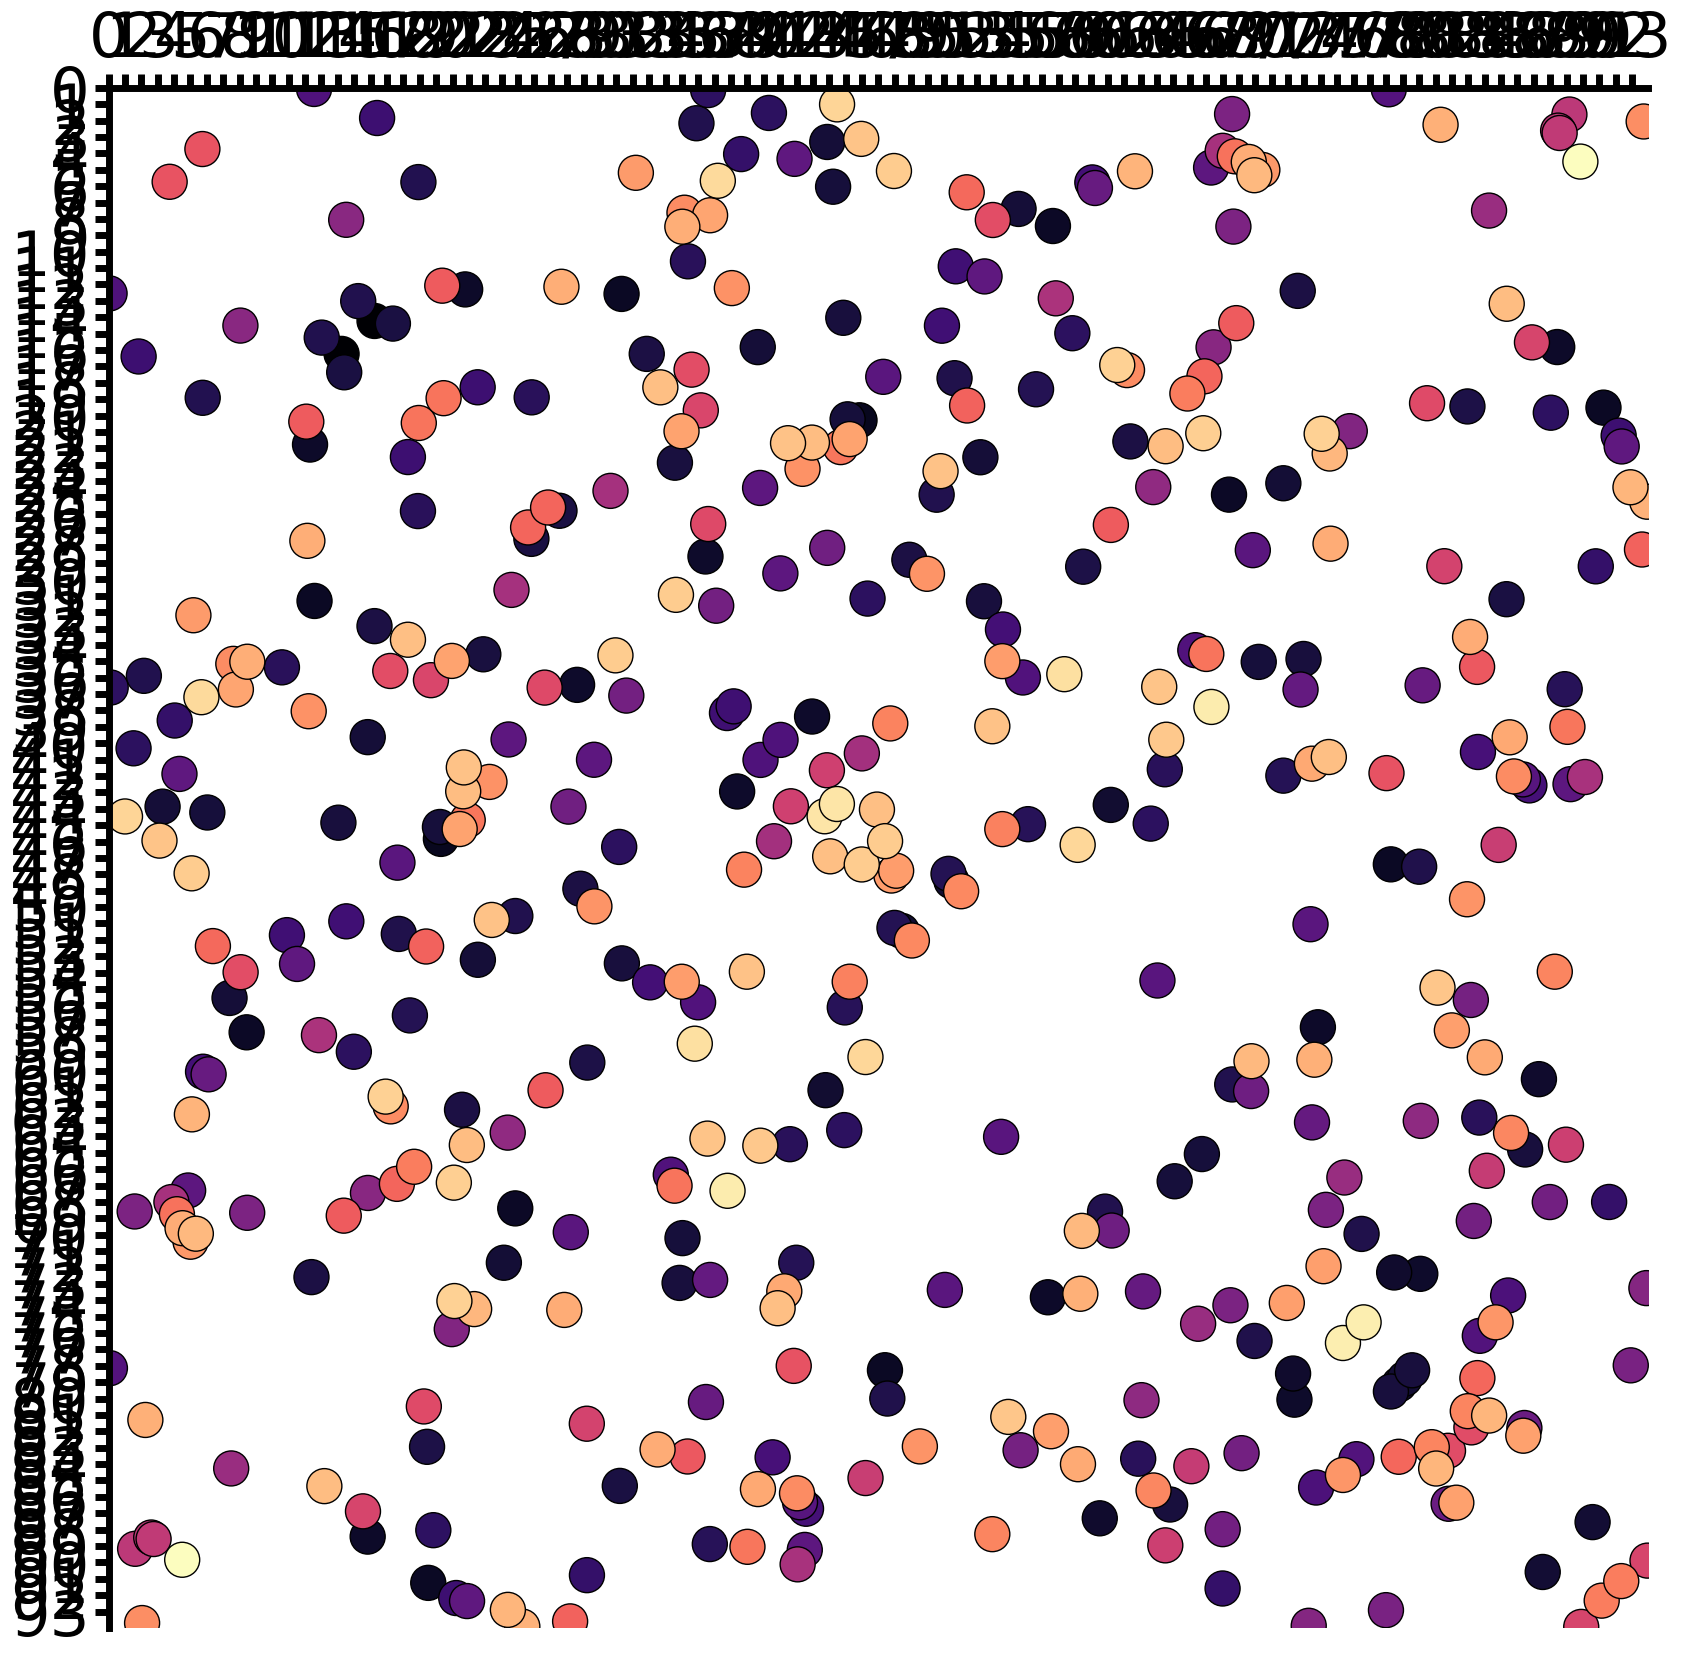

In [12]:
set_plt(figsize=(20, 20))
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
set_Border(plt.gca())

_scatter_xs, _scatter_ys = [], []
_pseudotimes = []
_rna_names = []
for rna_name in rna.obs.sort_values(by='dpt_pseudotime').index:
    if rna_name not in scHiC.keys():
        continue
    _pseudotime = rna[rna_name].obs['dpt_pseudotime'].values[0]
    _hic = array2mat(scHiC[rna_name]).copy()
    _hic += abs(_hic.min())
    
    _where = np.where(np.ones(_hic.shape))
    _where = list(zip(_where[0], _where[1]))
    _test = np.zeros(len(_where), dtype=object)
    for i in range(len(_where)):
        _test[i] = _where[i]
    _where = _test
    _p = np.triu(_hic, 1).reshape(-1)
    _p /= _p.sum()

    _scatter_x, _scatter_y = [], []
    for (i, j) in np.random.choice(_where, 1, p=_p):
        _i, _j = random.random()+i, random.random()+j
        if i == j:
            _i, _j = max(_i, _j), min(_i, _j)
        _scatter_x.append(_i)
        _scatter_y.append(_j)

    _i, _j = _scatter_x.copy(), _scatter_y.copy()
    _scatter_x.extend(_j), _scatter_y.extend(_i)

    _scatter_xs.extend(_scatter_x), _scatter_ys.extend(_scatter_y)
    _pseudotimes.extend([_pseudotime]*len(_scatter_x))
    _rna_names.extend([rna_name]*len(_scatter_x))

plt.scatter(_scatter_xs, _scatter_ys, edgecolors='black',
            s=(figure_size['large']*72./fig.dpi)**2, c=_pseudotimes, cmap='magma')

_len = array2mat(scHiC.get(next(iter(scHiC)))).shape[0]
plt.xticks([i for i in range(_len)])
plt.yticks([i for i in range(_len)])
plt.xlim((0, _len))
plt.ylim((0, _len))

ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('none')
ax.spines['top'].set_linewidth(figure_size['very_small'])

ax.xaxis.set_ticks_position('top')
ax.invert_yaxis()
ax.set_aspect('equal', adjustable='box')

plt.tick_params(colors='black', top=True, bottom=False, left=True, labelsize=figure_size['ultra'])
plt.grid(False)
# plt.savefig(
#     '/lmh_data/work/SEE/analyse/figure_file/{} heatmap(ODC).pdf'.format(gene_name),
#     format='pdf', bbox_inches='tight')
plt.show()

In [13]:
_partition = [
    rna.obs[rna.obs.dpt_pseudotime<=0.5],
    rna.obs[rna.obs.dpt_pseudotime>0.5]
]

pseudo_bulk_hic = []

for i in range(len(_partition)):
    _pseudo_bulk = None
    for rna_name in _partition[i].index:
        if rna_name not in scHiC.keys():
            continue

        _hic = array2mat(scHiC[rna_name]).copy()
        _hic += abs(_hic.min())
        if _pseudo_bulk is None:
            _pseudo_bulk = _hic
        else:
            _pseudo_bulk += _hic

    pseudo_bulk_hic.append(_pseudo_bulk / len(_partition[i]))
pseudo_bulk_hic

[array([[0.3445322197, 0.0267105662, 0.0252960363, ..., 0.0193979427,
         0.02362659  , 0.0185088231],
        [0.0267105662, 0.3594000931, 0.0424999474, ..., 0.026376717 ,
         0.0186093748, 0.0190966009],
        [0.0252960363, 0.0424999474, 0.3200970869, ..., 0.0219327295,
         0.0130957353, 0.0192367574],
        ...,
        [0.0193979427, 0.026376717 , 0.0219327295, ..., 0.3657434244,
         0.0422557077, 0.0284354988],
        [0.02362659  , 0.0186093748, 0.0130957353, ..., 0.0422557077,
         0.3712065291, 0.0403391067],
        [0.0185088231, 0.0190966009, 0.0192367574, ..., 0.0284354988,
         0.0403391067, 0.4472689496]]),
 array([[0.3172554476, 0.0281460104, 0.0248941578, ..., 0.0204560876,
         0.0249467062, 0.0209251688],
        [0.0281460104, 0.3130545496, 0.0424507622, ..., 0.0276077613,
         0.01737204  , 0.0219969659],
        [0.0248941578, 0.0424507622, 0.3028868917, ..., 0.0240823559,
         0.0150197901, 0.0224994787],
        ...,


In [14]:
import os
from velocity_util import Calculate_chromatin_conformation

def _draw(mat, title=None, ignore_diag=False):
    set_plt(figsize=(10, 10))
    sns.set_theme(style="whitegrid")

    fig, ax = plt.subplots()
    
    if ignore_diag:
        mat = mat.copy()
        np.fill_diagonal(mat, 0)
    ax = sns.heatmap(mat, cmap='Greys', square=True)

    set_Border(plt.gca())
    plt.grid(False)
    
    ax.set_xticks([])
    ax.set_yticks([])

#     if title:
#         plt.savefig(
#             '/lmh_data/work/SEE/analyse/figure_file/{}.pdf'.format(title), format='pdf', bbox_inches='tight')
    plt.show()

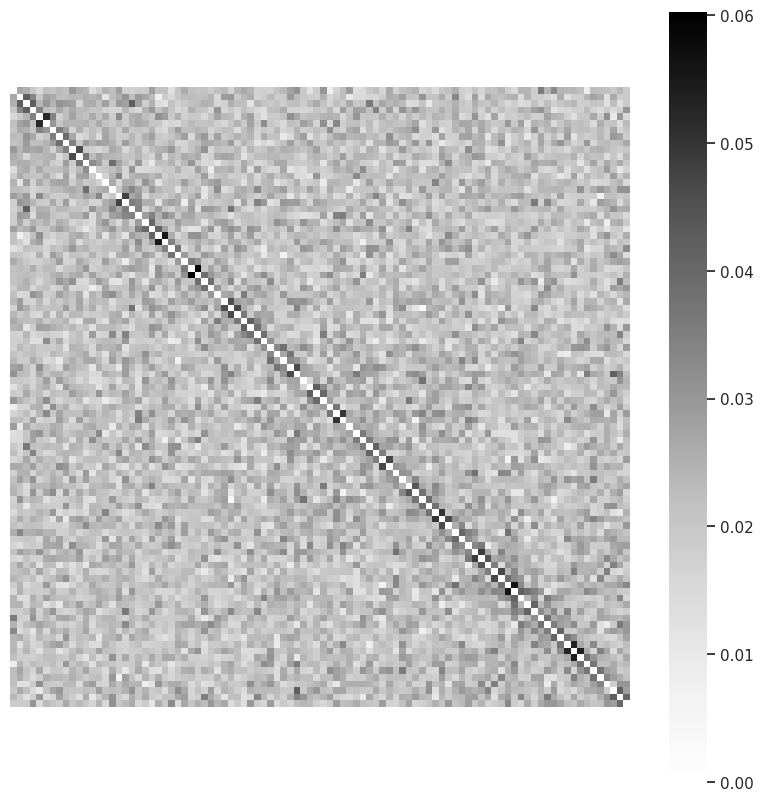

In [15]:
_draw(pseudo_bulk_hic[0], ignore_diag=True)

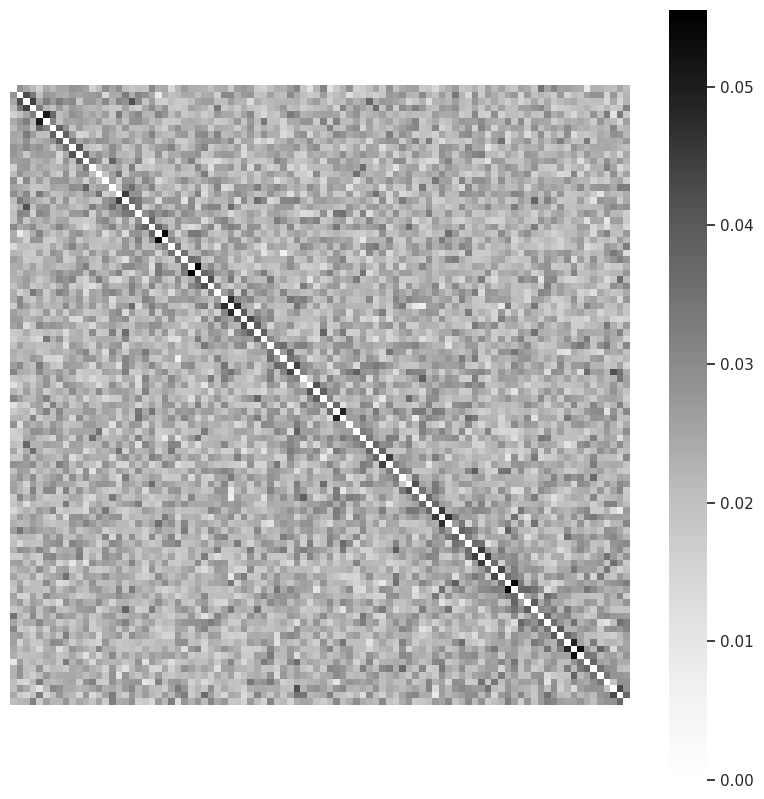

In [16]:
_draw(pseudo_bulk_hic[1], ignore_diag=True)

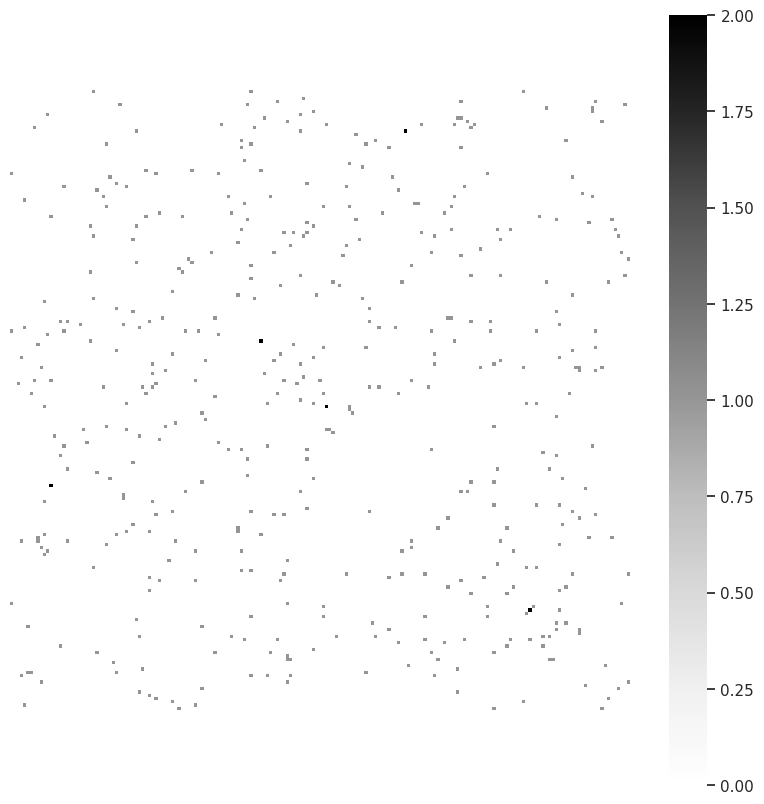

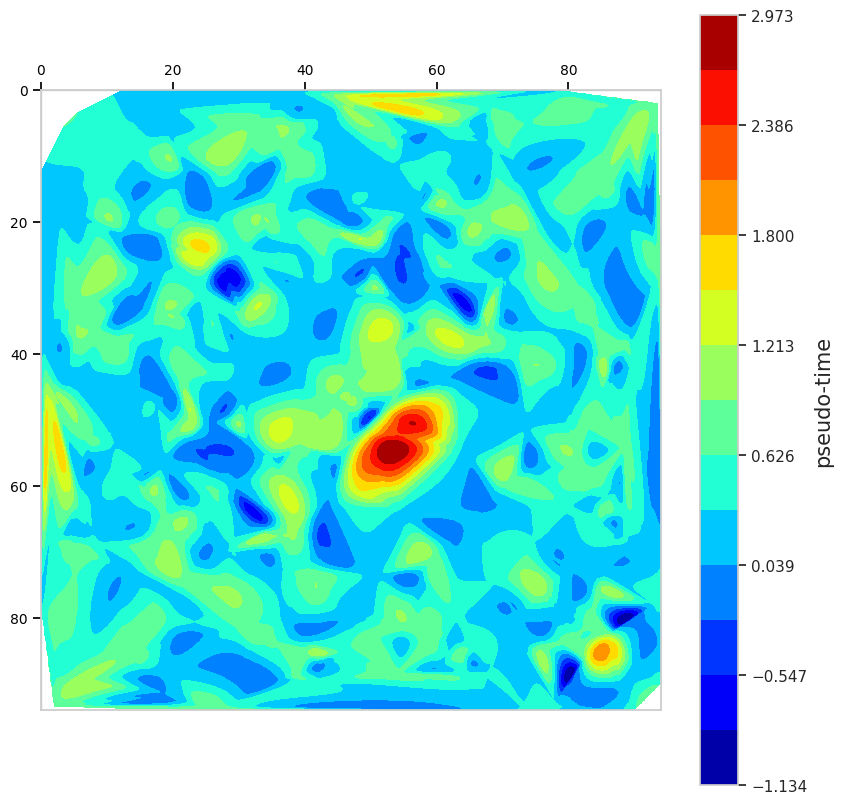

In [17]:
from scipy import interpolate

x = np.linspace(0, _len, _len*2+1)
y = np.linspace(0, _len, _len*2+1)
yy, xx = np.meshgrid(x, y)

def _norm(_decimal):
    if _decimal > 0.5:
        if 1 - _decimal >= _decimal - 0.5:
            return 0.5
        else:
            return 1
    else:
        if 0.5 - _decimal >= _decimal:
            return 0
        else:
            return 0.5

_count = np.zeros(xx.shape)
_value = np.zeros(xx.shape)
for i in range(len(_scatter_xs)):
    _decimal_x, _decimal_y = _scatter_xs[i] - int(_scatter_xs[i]), _scatter_ys[i] - int(_scatter_ys[i])
    _x, _y = int(_scatter_xs[i]) + _norm(_decimal_x), int(_scatter_ys[i]) + _norm(_decimal_y)
    _value[int(_x/0.5), int(_y/0.5)] += _pseudotimes[i]
    _count[int(_x/0.5), int(_y/0.5)] += 1

for i in range(_value.shape[0]):
    for j in range(_value.shape[1]):
        if _count[i, j] != 0:
            _value[i, j] /= _count[i, j]

_value[_count==0] = np.nan
_draw(_count, title='number of interaction occurrences({})'.format(gene_name))




set_plt(figsize=(10, 10))
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()

xx[_count==0] = yy[_count==0] = np.nan
xx, yy, new_value = xx.ravel(), yy.ravel(), _value.ravel()
xx, yy, new_value = list(xx[~np.isnan(xx)]), list(yy[~np.isnan(yy)]), list(new_value[~np.isnan(new_value)])

xnew = np.linspace(0, _len, _len*10+1)
ynew = np.linspace(0, _len, _len*10+1)
new_value = interpolate.griddata((xx, yy), new_value, (xnew[None,:], ynew[:,None]), method='cubic')

levels = np.linspace(min(new_value[~np.isnan(new_value)]), max(new_value[~np.isnan(new_value)]), 15)
cs = ax.contourf(xnew, ynew, new_value, levels=levels, cmap=plt.cm.jet)
cbar = plt.colorbar(cs)
cbar.set_label('pseudo-time', rotation=90, fontsize=15) # gas fraction

ax.xaxis.set_ticks_position('top')
ax.invert_yaxis()
ax.set_aspect('equal', adjustable='box')
plt.tick_params(colors='black', top=True, bottom=False, left=True, labelsize=figure_size['small'])

plt.savefig(
    '/lmh_data/work/SEE/analyse/figure_file/interactions distribution({}).pdf'.format(gene_name),
    format='pdf', bbox_inches='tight')

plt.show()

In [18]:
def get_pseudo_bulk_hic(_index):
    _pseudo_bulk = None
    for rna_name in set(np.array(_rna_names)[_index]):
        if rna_name not in scHiC.keys():
            continue

        _hic = array2mat(scHiC[rna_name]).copy()
        _hic += abs(_hic.min())
        if _pseudo_bulk is None:
            _pseudo_bulk = _hic
        else:
            _pseudo_bulk += _hic
    return _pseudo_bulk / len(set(np.array(_rna_names)[_index]))

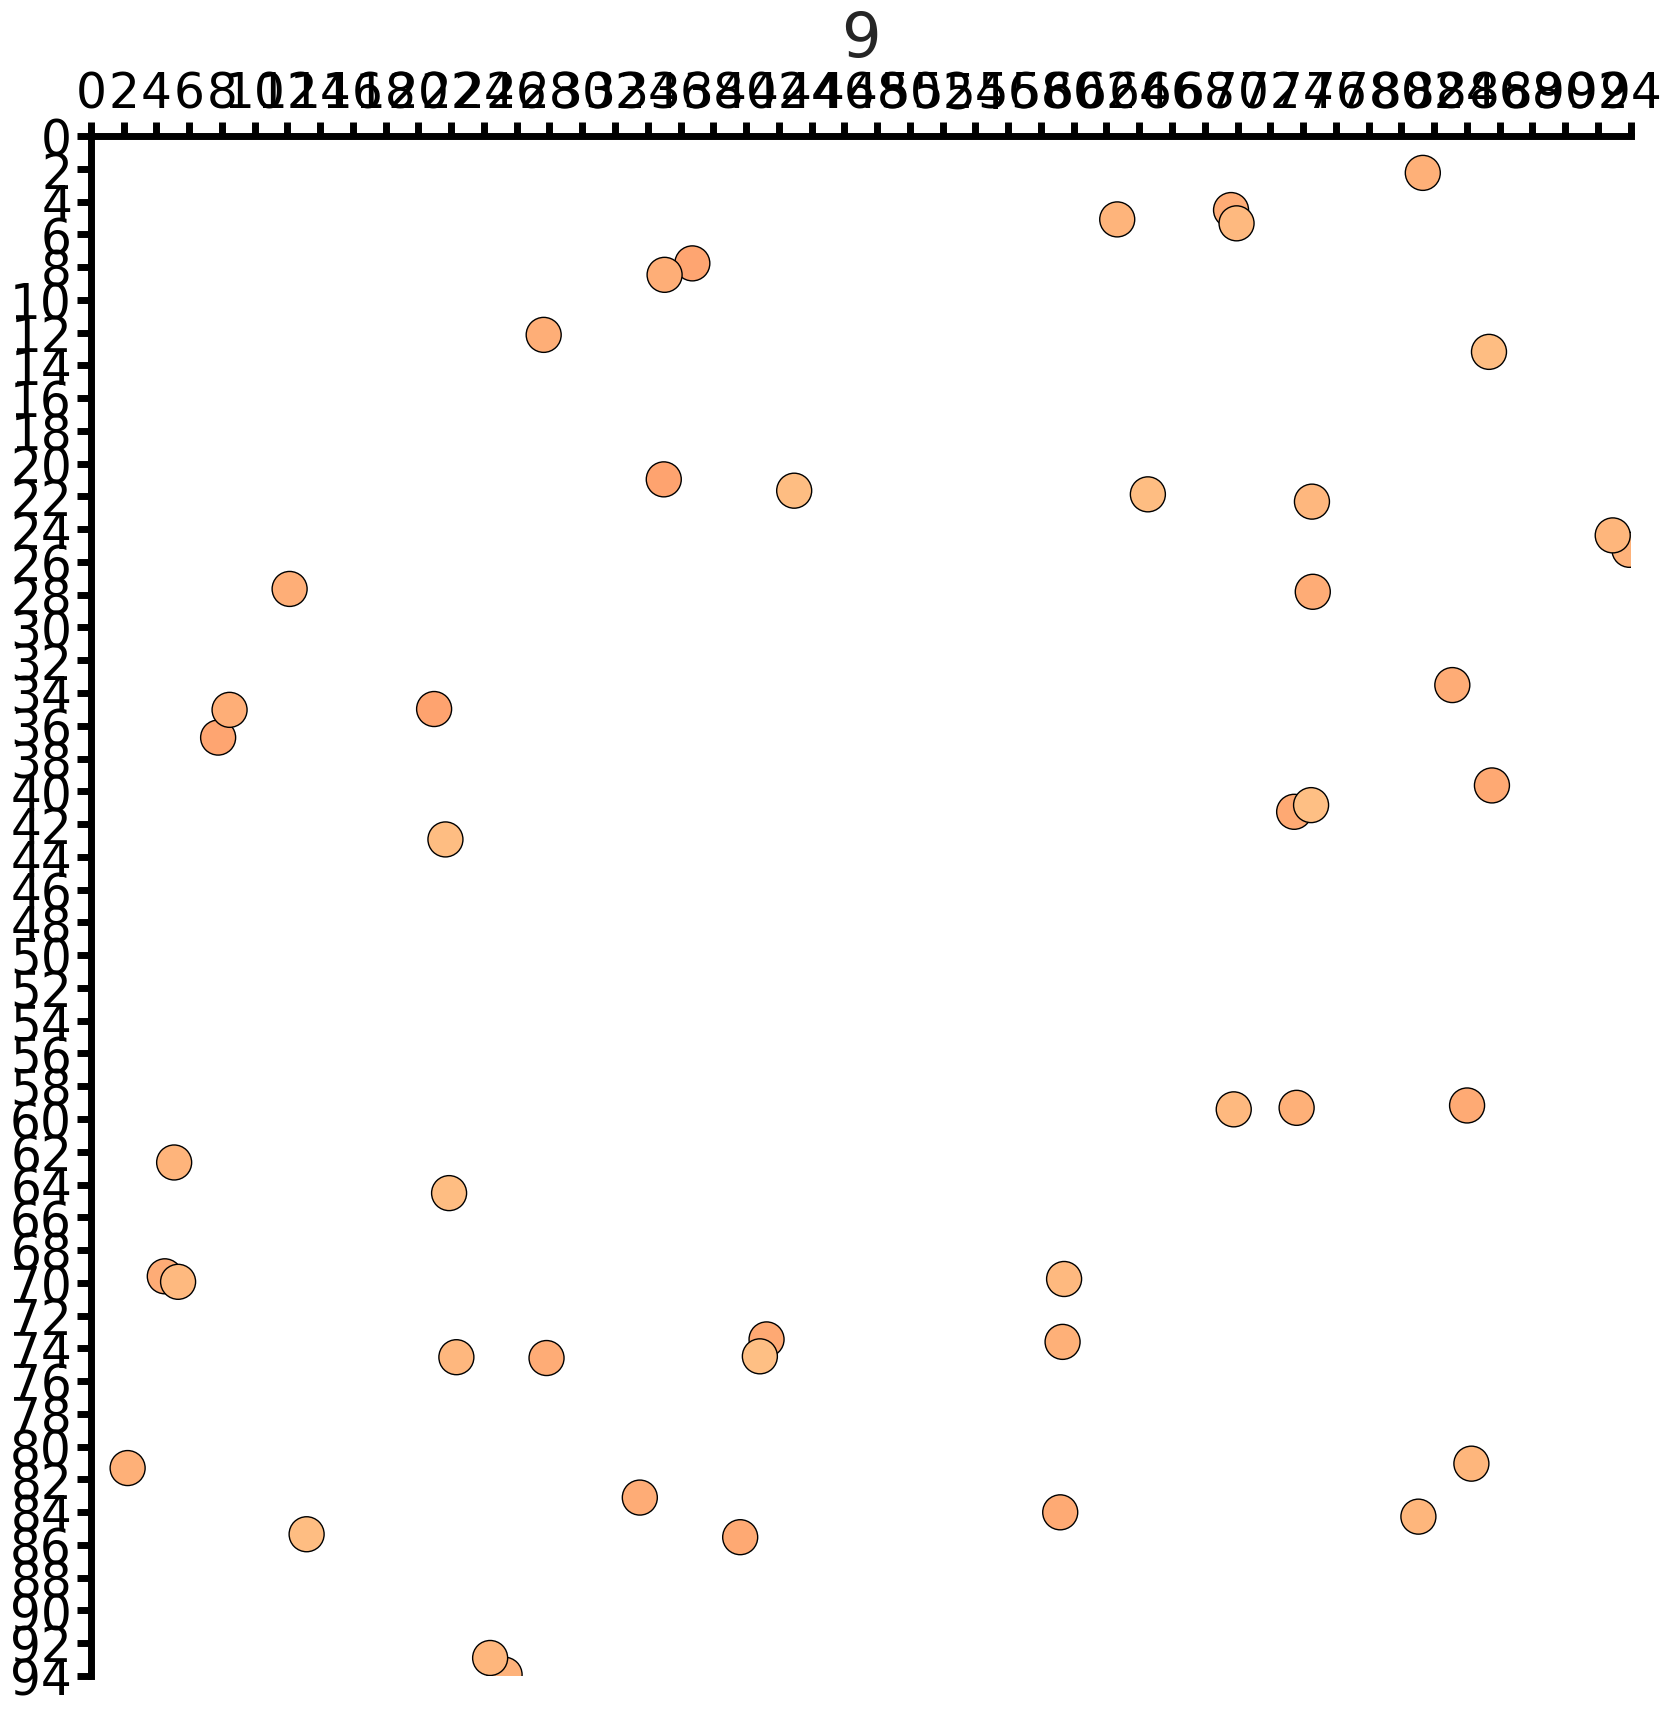

In [19]:
from IPython import display

_array_x, _array_y = np.array(_scatter_xs), np.array(_scatter_ys)
_array_pseudotimes = np.array(_pseudotimes)
_step = 10
for i in range(_step, 100, _step):
    _index = range(int(len(_array_pseudotimes)*(i-_step)/100), int(len(_array_pseudotimes)*(i)/100))
    if len(_index) == 0:
        continue
        
    set_plt(figsize=(20, 20))
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots()
    set_Border(plt.gca())

    plt.scatter(_array_x[_index], _array_y[_index], edgecolors='black',
            s=(figure_size['large']*72./fig.dpi)**2, c=_array_pseudotimes[_index], cmap='magma', vmin=0, vmax=1)
    Calculate_chromatin_conformation(get_pseudo_bulk_hic(_index)*1000, './{}/{}'.format(gene_name, int(i/_step)))

    plt.xlim((0, _len))
    plt.ylim((0, _len))

    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('none')
    ax.spines['top'].set_linewidth(figure_size['very_small'])

    ax.xaxis.set_ticks_position('top')
    ax.invert_yaxis()
    ax.set_aspect('equal', adjustable='box')

    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(2))
    
    plt.tick_params(colors='black', top=True, bottom=False, left=True, labelsize=figure_size['large'])
    plt.grid(False)
    
    plt.title('{}'.format(int(i/_step)), fontsize=figure_size['ultra'])
    file_name = '/lmh_data/work/SEE/analyse/figure_file/pseudo_time/{}/2D/{}.pdf'.format(gene_name, int(i/_step))
    mkdir(file_name)
    plt.savefig(file_name, format='pdf', bbox_inches='tight')
    
    display.clear_output(wait=True)
    plt.pause(0.00000001)

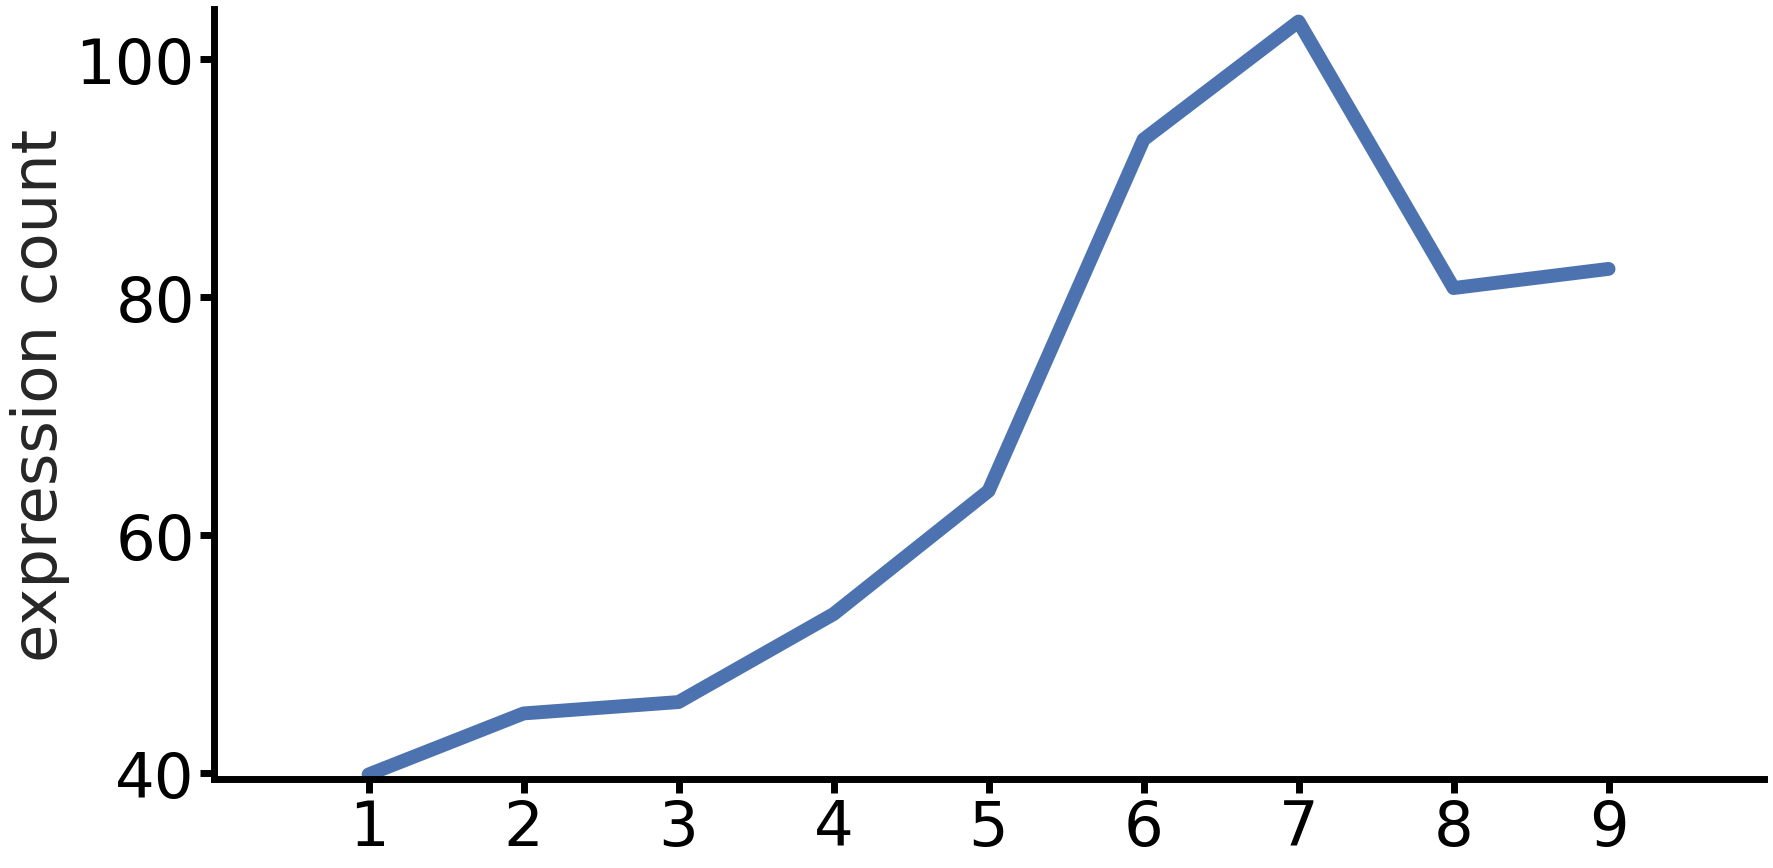

In [20]:
_expression_counts = []
for i in range(_step, 100, _step):
    _index = range(int(len(_array_pseudotimes)*(i-_step)/100), int(len(_array_pseudotimes)*(i)/100))
    if len(_index) == 0:
        continue
    _expression_counts.append(rna[list(set(np.array(_rna_names)[_index])), gene_name].X.mean())

from analyse_util import draw_pseudotime_line
mkdir('/lmh_data/work/SEE/analyse/figure_file/pseudo_time/{}/rna'.format(gene_name))
draw_pseudotime_line(_expression_counts, ylabel='expression count',
                     save_dir_path='/lmh_data/work/SEE/analyse/figure_file/pseudo_time/{}/rna'.format(gene_name))

In [21]:
from velocity_util import find_best_pdb, read_pdb

pseudo_time = [str(i) for i in range(1, 10)]
pseudo_time_3D = dict()

for _dir in pseudo_time:
    _pdb_path = find_best_pdb('./{}/{}'.format(gene_name, _dir))
    pseudo_time_3D[_dir] = read_pdb(_pdb_path)
    
pseudo_time_3D

{'1': array([[ 6.259e+00,  7.780e-01, -4.445e+00],
        [ 3.610e+00,  5.331e+00, -3.573e+00],
        [ 1.253e+00,  7.275e+00, -6.180e-01],
        [-3.950e+00,  6.139e+00,  7.250e-01],
        [-3.680e-01,  5.956e+00,  3.053e+00],
        [ 4.408e+00,  2.816e+00, -3.475e+00],
        [ 2.957e+00,  3.133e+00, -4.651e+00],
        [ 7.073e+00,  2.009e+00,  1.515e+00],
        [ 3.276e+00,  5.858e+00, -1.691e+00],
        [ 1.775e+00,  5.774e+00,  2.980e+00],
        [-3.130e+00,  4.857e+00, -2.052e+00],
        [-9.010e-01,  6.872e+00, -3.351e+00],
        [-3.730e+00,  6.693e+00, -3.543e+00],
        [-1.430e+00,  7.523e+00, -7.480e-01],
        [ 1.740e+00,  2.218e+00, -6.640e+00],
        [ 4.008e+00, -1.122e+00, -3.570e+00],
        [ 9.220e-01,  6.048e+00, -4.010e+00],
        [ 5.469e+00,  4.617e+00, -1.348e+00],
        [ 2.539e+00,  4.384e+00, -1.230e-01],
        [ 3.640e+00,  4.007e+00,  3.697e+00],
        [ 4.630e+00,  2.936e+00,  4.670e+00],
        [ 2.329e+00,  3.463e+

In [22]:
def rotate(points1, points2):
    if (points1 == points2).all():
        return points1
    # 求解协方差矩阵C
    centroid1 = np.mean(points1, axis=0)
    centroid2 = np.mean(points2, axis=0)
    demeaned1 = points1 - centroid1
    demeaned2 = points2 - centroid2
    C = np.dot(demeaned1.T, demeaned2)

    # 使用SVD分解C得到旋转矩阵R
    U, S, Vt = np.linalg.svd(C)
    R = np.dot(U, Vt)
    
    points_rotated = np.dot(points2, R)
    return points_rotated

for i in pseudo_time:
    pseudo_time_3D[i] = rotate(pseudo_time_3D[pseudo_time[0]], pseudo_time_3D[i])

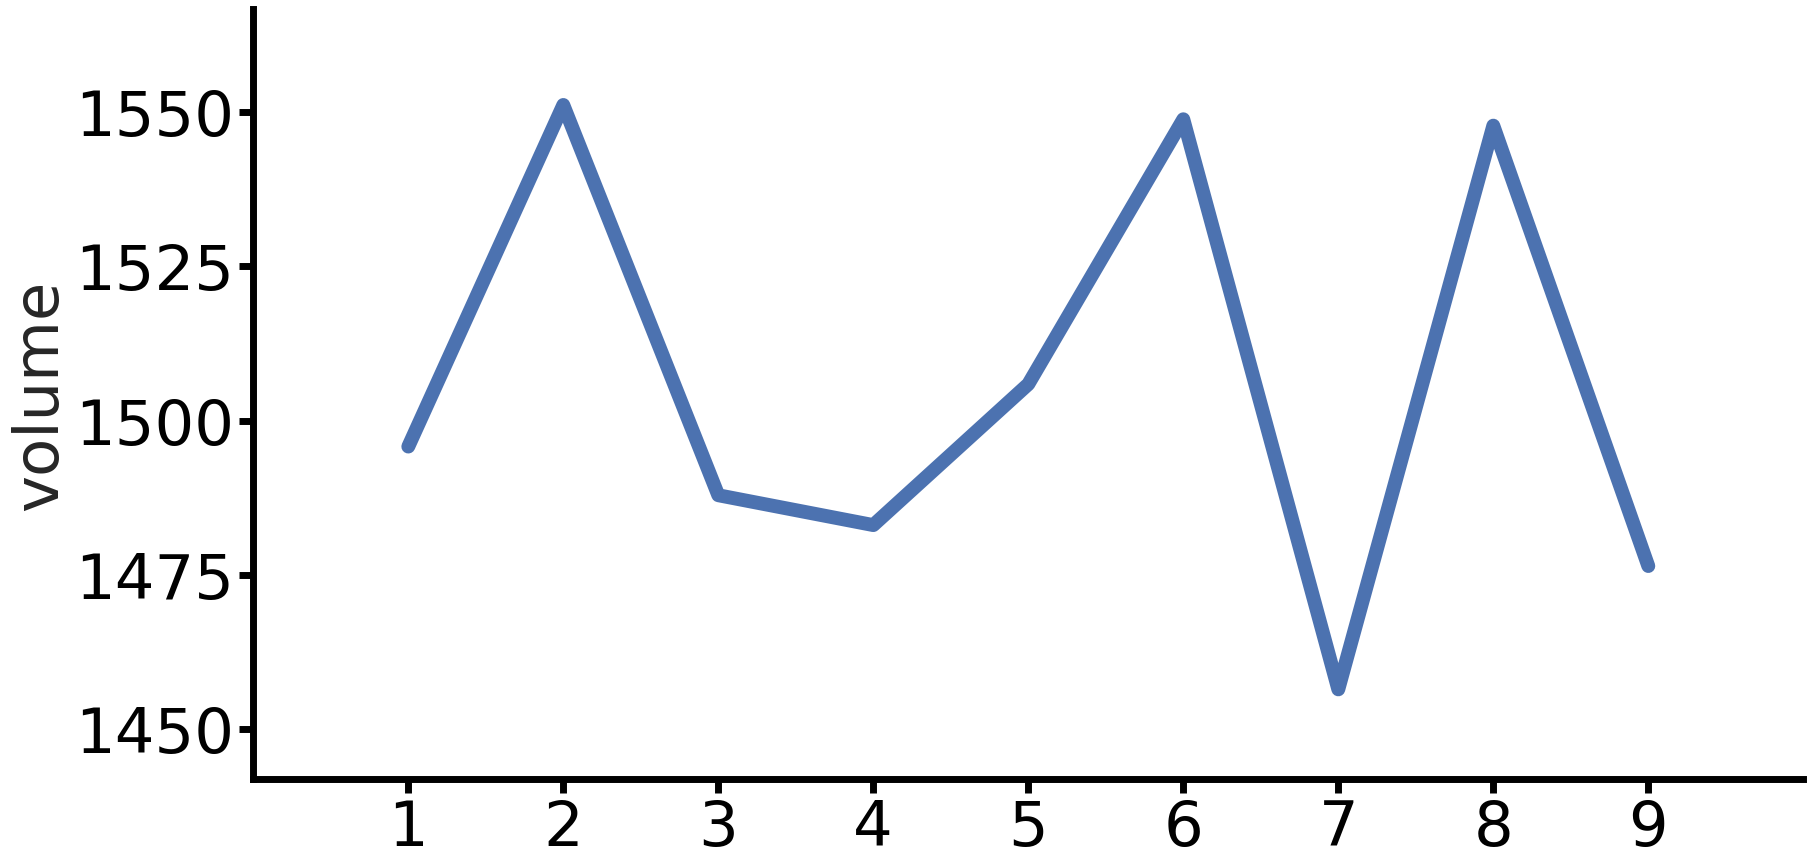

In [23]:
from scipy.spatial import ConvexHull

def calculate_volume(points):
    return ConvexHull(points).volume
volumes = [calculate_volume(pseudo_time_3D[i]) for i in pseudo_time]

from analyse_util import draw_pseudotime_line
mkdir('/lmh_data/work/SEE/analyse/figure_file/pseudo_time/{}/volume'.format(gene_name))
draw_pseudotime_line(volumes, ylabel='volume',
                     save_dir_path='/lmh_data/work/SEE/analyse/figure_file/pseudo_time/{}/volume'.format(gene_name))

In [24]:
np.save('./temp/{}.npy'.format(gene_name), {
    'expression_counts': _expression_counts,
    'volumes': volumes,
})

Making directory: /lmh_data/work/SEE/analyse/figure_file/pseudo_time/PCDH9/3D


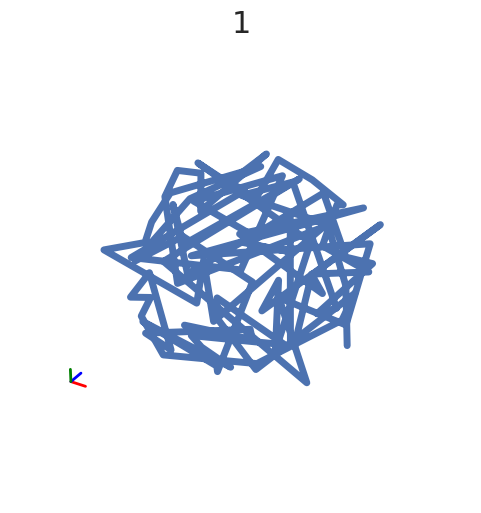

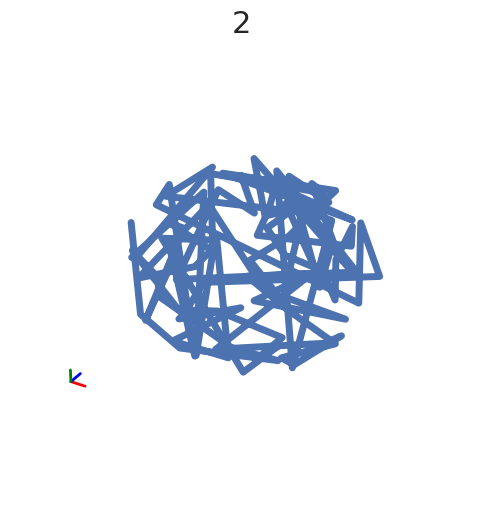

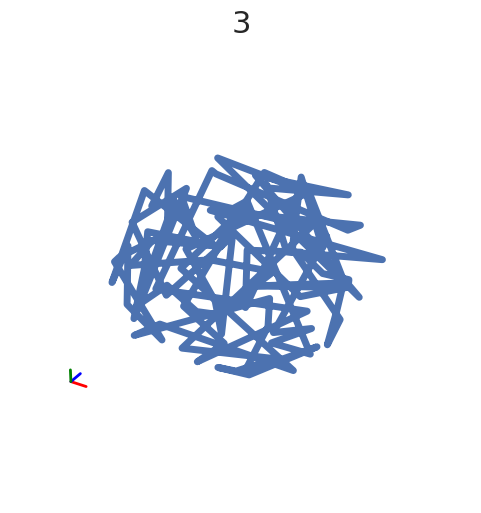

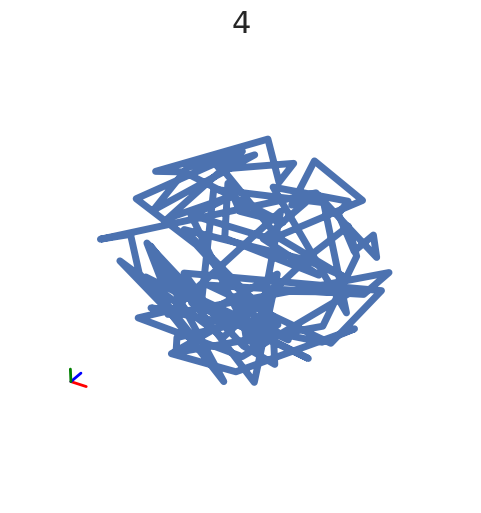

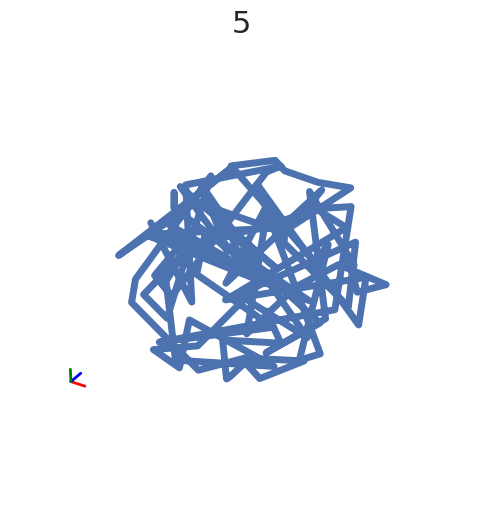

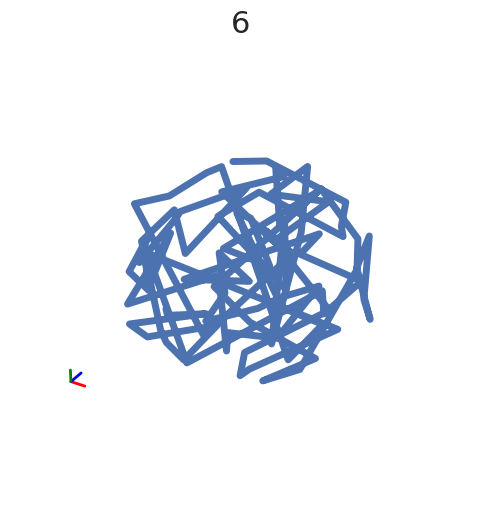

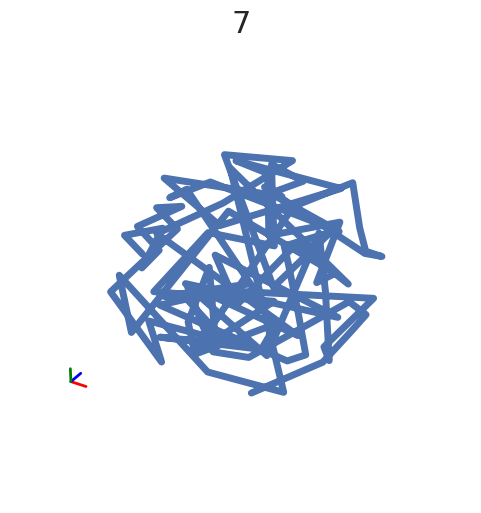

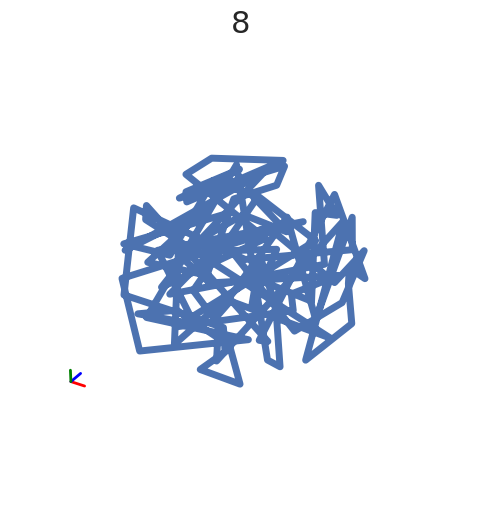

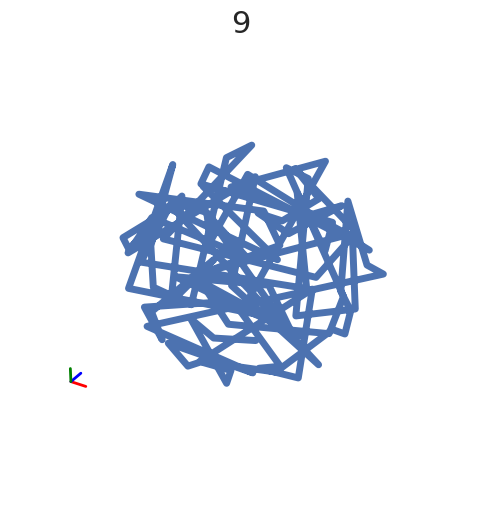

In [25]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )
    return new_cmap

def show(points, title):
    very_large = 24; large = 22; med = 16; small = 12
    params = {'axes.titlesize': very_large,
              'legend.fontsize': med,
              'figure.figsize': (6, 6),
              'axes.labelsize': large,
              'axes.titlesize': large,
              'xtick.labelsize': large,
              'ytick.labelsize': large,
              'figure.titlesize': very_large,
              'lines.linewidth': 2}
    plt.rcParams.update(params)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    ax.plot(points[:, 0], points[:, 1], points[:, 2], '-', linewidth=5)

    origin = [min(points[:, 0]), min(points[:, 1]), min(points[:, 2])]
    ax.plot([origin[0], origin[0]+1], [origin[1], origin[1]], [origin[2], origin[2]], '-', color='red')
    ax.plot([origin[0], origin[0]], [origin[1], origin[1]+1], [origin[2], origin[2]], '-', color='blue')
    ax.plot([origin[0], origin[0]], [origin[1], origin[1]], [origin[2], origin[2]+1], '-', color='green')
    
#     fig.colorbar(scatter, ax=ax, fraction=0.02)
    ax.grid(False)
    ax.axis("off")

    plt.title('{}'.format(title))
    file_name = '/lmh_data/work/SEE/analyse/figure_file/pseudo_time/{}/3D/{}.pdf'.format(gene_name, title)
    mkdir(file_name)
    plt.savefig(file_name, format='pdf', bbox_inches='tight')
    plt.show()

for i in pseudo_time:
    show(pseudo_time_3D[str(i)], i)